In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression,Lasso,LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import classification_report, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay,precision_recall_curve
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import FunctionTransformer
from matplotlib import rcParams
from snownlp import SnowNLP
import re
rcParams['font.sans-serif'] = ['Microsoft YaHei']
rcParams['axes.unicode_minus'] = False
pd.set_option('display.max_columns', None)

In [11]:
train=pd.read_csv('Data/train.csv')
test=pd.read_csv('Data/test.csv')
test.head()

,id,name,description,property_type,neighbourhood_cleansed,neighbourhood_group_cleansed,latitude,longitude,host_since,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_listings_count,host_total_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,room_type,accommodates,bathrooms,bathrooms_text,bedrooms,beds,amenities,has_availability,availability_30,availability_60,availability_90,availability_365,instant_bookable,minimum_nights,maximum_nights,number_of_reviews,number_of_reviews_ltm,number_of_reviews_l30d,first_review,last_review,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,reviews_per_month,reviews
0,3917,"Beautiful 3 bedroom House in Woodside, Queens",Beautiful 3 bedroom house in the heart of Wood...,Entire home,Woodside,Queens,40.744620,-73.904520,2013-05-07 00:00:00,NaN,NaN,NaN,False,1.0,12.0,"['email', 'phone']",True,True,1,1,0,0,Entire home/apt,6,1.5,1.5 baths,3.0,4.0,"[""Dishwasher"", ""Dining table"", ""Keypad"", ""Smok...",True,29,59,89,89,False,30,90,28,2,0,2022-10-17 00:00:00,2023-09-17 00:00:00,5.00,5.00,4.96,5.00,5.00,4.96,4.96,1.22,Home was perfect and exactly what we needed to...
1,1885,"Queens HDTV Room 13 mins to Manhattan, 3 bath ...",Bright bedroom in the best part of Long Island...,Private room in rental unit,Long Island City,Queens,40.753407,-73.934995,2012-08-11 00:00:00,within an hour,99.0,23.0,False,727.0,1336.0,"['email', 'phone']",True,True,719,0,719,0,Private room,1,3.0,3 shared baths,4.0,1.0,"[""Kitchen"", ""Hot water"", ""Dedicated workspace""...",True,29,59,89,364,False,30,365,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1305,Lovely Bright & Spacious Loft in Brooklyn.,"Our loft is spacious and calm, filled with nat...",Entire loft,Crown Heights,Brooklyn,40.677090,-73.943810,2012-05-14 00:00:00,NaN,NaN,NaN,False,1.0,1.0,"['email', 'phone']",True,True,1,1,0,0,Entire home/apt,2,1.0,1 bath,1.0,1.0,"[""Kitchen"", ""Hair dryer"", ""Iron"", ""Heating"", ""...",True,29,59,89,89,False,30,365,31,0,0,2021-10-17 00:00:00,2022-10-31 00:00:00,4.94,5.00,4.90,4.90,4.97,4.68,4.90,0.88,I would give this place 10 stars if it were op...
3,19328,Classic Petite Room SB #17 - Furnished Studio,"Extended stay hotel , all rooms are fully furn...",Entire rental unit,Upper West Side,Manhattan,40.795760,-73.971570,2021-04-05 00:00:00,within a day,70.0,37.0,False,36.0,79.0,"['email', 'phone']",True,True,36,18,18,0,Entire home/apt,1,3.0,3 baths,0.0,1.0,"[""Kitchen"", ""Hair dryer"", ""Hot water"", ""Dedica...",True,0,0,0,157,False,30,500,4,3,1,2023-05-29 00:00:00,2024-08-21 00:00:00,4.75,4.50,4.75,5.00,4.50,5.00,4.50,0.26,The front-desk staff was absolutely wonderful ...
4,16511,Petit chalet with secret garden,Small loft type of apartment on ground floor w...,Entire rental unit,Williamsburg,Brooklyn,40.713590,-73.955400,2014-10-07 00:00:00,within a few hours,100.0,75.0,False,1.0,1.0,"['email', 'phone']",True,True,1,1,0,0,Entire home/apt,2,1.0,1 bath,0.0,1.0,"[""Coffee maker: pour-over coffee"", ""Cleaning p...",True,3,12,24,113,False,30,60,157,2,1,2015-02-22 00:00:00,2024-08-31 00:00:00,4.82,4.89,4.69,4.97,4.96,4.94,4.73,1.35,I really enjoyed staying at Kanae's place. It ...


In [12]:
train.isnull().sum()

name                                               0
description                                      387
property_type                                      0
price                                              0
neighbourhood_cleansed                             0
neighbourhood_group_cleansed                       0
latitude                                           0
longitude                                          0
host_since                                         0
host_response_time                              2203
host_response_rate                              2203
host_acceptance_rate                            2053
host_is_superhost                                251
host_listings_count                                0
host_total_listings_count                          0
host_verifications                                 0
host_has_profile_pic                               0
host_identity_verified                             0
calculated_host_listings_count                

In [13]:
class SentimentScoreTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        sentiment_scores = X['reviews'].fillna('').apply(
            lambda text: SnowNLP(text).sentiments if text else 0.5
        )
        return sentiment_scores.to_frame(name='sentiment_score')

In [108]:
class DistanceFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, locations):
        self.locations = locations
    def fit(self, X, y=None):
        return self
    
    def haversine_distance(self, lat1, lon1, lat2, lon2):
        lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
        dlat = lat2 - lat1
        dlon = lon2 - lon1
        a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
        c = 2 * np.arcsin(np.sqrt(a))
        r = 6371  
        return c * r

    def transform(self, X):
        transformed_data = pd.DataFrame(index=X.index)    
        for location_name, (lat2, lon2) in self.locations.items():
            transformed_data[f'distance_to_{location_name}'] = X.apply(
                lambda row: self.haversine_distance(row['latitude'], row['longitude'], lat2, lon2), axis=1
            )
        
        return transformed_data

    def get_feature_names_out(self, input_features=None):
        return np.array([f'distance_to_{name}' for name in self.locations.keys()])
    #def get_feature_names(self):
    #    return [f'distance_to_{name}' for name in self.locations.keys()]

In [110]:
class ListTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.unique_values = {}

    def fit(self, X, y=None):
        for col in self.columns:
            self.unique_values[col] = set()
            X[col].dropna().apply(lambda x: self.unique_values[col].update(x))
        return self

    def transform(self, X):
        X_transformed = X.copy()
        for col in self.columns:
            for value in self.unique_values[col]:
                X_transformed[f"{col}_{value}"] = X_transformed[col].apply(
                    lambda x: 1 if x is not None and value in x else 0
                )
            X_transformed.drop(columns=[col], inplace=True)
        return X_transformed
    def get_feature_names_out(self, input_features=None):
        feature_names = []
        for col in self.columns:
            for value in self.unique_values[col]:
                feature_names.append(f"{col}_{value}")
        return np.array(feature_names)

In [112]:
class LuxuryFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, luxury_keywords=None):
        if luxury_keywords is None:
            self.luxury_keywords = ['luxury',  'elegant', 'modern', 'exclusive']
        else:
            self.luxury_keywords = luxury_keywords

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        pattern = re.compile('|'.join(self.luxury_keywords), re.IGNORECASE)
        is_luxury = X['name'].fillna('') + ' ' + X['description'].fillna('')
        is_luxury = is_luxury.apply(lambda x: 1 if pattern.search(x) else 0)
        return is_luxury.to_frame(name='is_luxury')
    def get_feature_names_out(self, input_features=None):
        return np.array(['is_luxury'])

class AmenitiesTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, luxury_amenities=None):
        if luxury_amenities is None:
            self.luxury_amenities = ['pool', 'jacuzzi', 'gym', 'sauna', 'hot tub']
        else:
            self.luxury_amenities = luxury_amenities

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        amenities_df = pd.DataFrame(index=X.index)
        # Count total amenities
        amenities_df['num_amenities'] = X['amenities'].fillna('[]').apply(
            lambda x: len(eval(x)) if isinstance(x, str) else 0
        )
        for amenity in self.luxury_amenities:
            amenities_df[f'has_{amenity.replace(" ", "_")}'] = X['amenities'].fillna('[]').apply(
                lambda x: 1 if amenity.lower() in map(str.lower, eval(x)) else 0
            )
        return amenities_df

    def get_feature_names_out(self, input_features=None):
        feature_names = ['num_amenities']
        for amenity in self.luxury_amenities:
            feature_names.append(f'has_{amenity.replace(" ", "_")}')
        return np.array(feature_names)

luxury_transformer = Pipeline(steps=[
    ('luxury_features', LuxuryFeatureTransformer())
])

amenities_transformer = Pipeline(steps=[
    ('amenities_features', AmenitiesTransformer())
])

In [114]:
class PositiveReviewTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, positive_words=None):
        if positive_words is None:
            self.positive_words = [ 'amazing', 'excellent', 'fantastic', 'wonderful', 'perfect', 'clean', 'comfortable']
        else:
            self.positive_words = positive_words

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        pattern = re.compile('|'.join(self.positive_words), re.IGNORECASE)
        positive_reviews = X['reviews'].fillna('').apply(
            lambda text: 1 if pattern.search(text) else 0
        )
        return positive_reviews.to_frame(name='is_positive_review')

    def get_feature_names_out(self, input_features=None):
        return np.array(['is_positive_review'])

positive_review_transformer = Pipeline(steps=[
    ('positive_reviews', PositiveReviewTransformer())
])


In [116]:
numeric_features = ['host_response_rate', 'host_acceptance_rate', 'host_listings_count', 'host_total_listings_count', 'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
'calculated_host_listings_count_private_rooms', 'calculated_host_listings_count_shared_rooms','accommodates','bathrooms','bedrooms','beds','availability_30','availability_60','availability_90','availability_365',
'minimum_nights','maximum_nights','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d', 'review_scores_rating','review_scores_accuracy',
'review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','reviews_per_month']

categorical_features = ['host_response_time','property_type', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'host_verifications','room_type']#,'amenities']

list_features = ['host_verifications', 'amenities']

geo_features = ['latitude', 'longitude']

locations = {
    'manhattan': (40.7831, -73.9712),
    'brooklyn': (40.6782, -73.9442),
    'queens': (40.7282, -73.7949),
    'bronx': (40.8448, -73.8648),
    'staten_island': (40.5795, -74.1502)
}

review_features = ['reviews']

In [122]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Cat pipeline
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

list_transformer = ListTransformer(columns=list_features)

geo_transformer = Pipeline(steps=[
    ('distance_features', DistanceFeatureTransformer(locations=locations))
])

sentiment_transformer = Pipeline(steps=[
    ('sentiment_score', SentimentScoreTransformer())
])

calculate_host_duration = FunctionTransformer(
    func=lambda x: (pd.to_datetime('2025-01-01') - pd.to_datetime(x['host_since'])).dt.days.values.reshape(-1, 1),
    feature_names_out=lambda self, input_features: ['host_duration']
)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features),
        ('list', list_transformer, list_features),
        ('geo', geo_transformer, geo_features),
        ('luxury', luxury_transformer, ['name', 'description']),
        ('amenities', amenities_transformer, ['amenities']),
        ('positive_reviews', positive_review_transformer, ['reviews']),
        ('host_duration', calculate_host_duration, ['host_since'])
    ],
    remainder='passthrough'
)

In [29]:
target = 'price'
X = train.drop(columns=[target,'bathrooms_text','first_review','last_review','first_review'])
y = train[target]
# Split the data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

In [31]:
param = {
    'regressor__n_estimators': [100, 200, 300, 500],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__subsample': [0.6, 0.8, 1.0],
    'regressor__colsample_bytree': [0.6, 0.8, 1.0],
    'regressor__reg_alpha': [0, 0.1, 1],
    'regressor__reg_lambda': [0.1, 1, 10]
}

best_params = {
    'subsample': 0.8,
    'reg_lambda': 1,
    'reg_alpha': 1,
    'n_estimators': 500,
    'max_depth': 7,
    'learning_rate': 0.1,
    'colsample_bytree': 1.0
}

In [33]:
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(**best_params))
])

In [35]:
model_rf.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['host_response_rate',
                                                   'host_acceptance_rate',
                                                   'host_listings_count',
                                                   'host_total_listings_count',
                                                   'calculated_host_listings_count',
                                                   'calculated_host_listings_count_entire_homes',
                                                   'calcul...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.1,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=7, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, random_state=None, ...))])

In [37]:
y_pred_rf = np.round(model_rf.predict(X_valid))

In [39]:
mse = mean_squared_error(y_valid, y_pred_rf)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_valid, y_pred_rf)
r2 = r2_score(y_valid, y_pred_rf)

In [41]:
print(f"MSE: {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"R²: {r2:.2f}")

MSE: 0.59331
RMSE: 0.77027
MAE: 0.44936
R²: 0.80


In [43]:
from sklearn.model_selection import RandomizedSearchCV

In [45]:
random_search = RandomizedSearchCV(model_rf, param, n_iter=50, cv=5, scoring='neg_mean_squared_error', verbose=2, n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer()),
                                                                                               ('scaler',
                                                                                                StandardScaler())]),
                                                                               ['host_response_rate',
                                                                                'host_acceptance_rate',
                                                                                'host_listings_count',
                                                                                'host_total_listings_count',
                                                                                'calculated_host_listings_count',
                                                                                'calculated_host_li...
                   n_iter=50, n_jobs=-1,
                   param_distributions={'regressor__colsample_bytree': [0.6,
                                                                        0.8,
                                                                        1.0],
                                        'regressor__learning_rate': [0.01, 0.05,
                                                                     0.1],
                                        'regressor__max_depth': [3, 5, 7],
                                        'regressor__n_estimators': [100, 200,
                                                                    300, 500],
                                        'regressor__reg_alpha': [0, 0.1, 1],
                                        'regressor__reg_lambda': [0.1, 1, 10],
                                        'regressor__subsample': [0.6, 0.8,
                                                                 1.0]},
                   random_state=42, scoring='neg_mean_squared_error',
                   verbose=2)

In [46]:
print("Best parameters found: ", random_search.best_params_)

Best parameters found:  {'regressor__subsample': 0.8, 'regressor__reg_lambda': 0.1, 'regressor__reg_alpha': 1, 'regressor__n_estimators': 500, 'regressor__max_depth': 5, 'regressor__learning_rate': 0.1, 'regressor__colsample_bytree': 0.6}


In [47]:
y_pred = np.round(random_search.best_estimator_.predict(X_valid))
mse = mean_squared_error(y_valid, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_valid, y_pred)
r2 = r2_score(y_valid, y_pred)

In [48]:
print(f"MSE: {mse:.5f}")
print(f"RMSE: {rmse:.5f}")
print(f"MAE: {mae:.5f}")
print(f"R²: {r2:.5f}")

MSE: 0.59713
RMSE: 0.77274
MAE: 0.46592
R²: 0.79756


In [59]:
y_test_pred = random_search.best_estimator_.predict(test)

In [50]:
submission = pd.DataFrame({
    'id': test['id'],  
    'price': np.round(y_test_pred) 
})

In [51]:
submission.to_csv('submission7.csv', index=False)

In [100]:
model = random_search.best_estimator_.named_steps['regressor']
feature_importances = model.feature_importances_

In [86]:
def plot_feature_importance(importance_df, title):
    plt.figure(figsize=(10, 6))
    plt.barh(importance_df['Feature'], importance_df['Importance'])
    plt.xlabel('Importance')
    plt.title(title)
    plt.gca().invert_yaxis()
    plt.show()

In [124]:
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

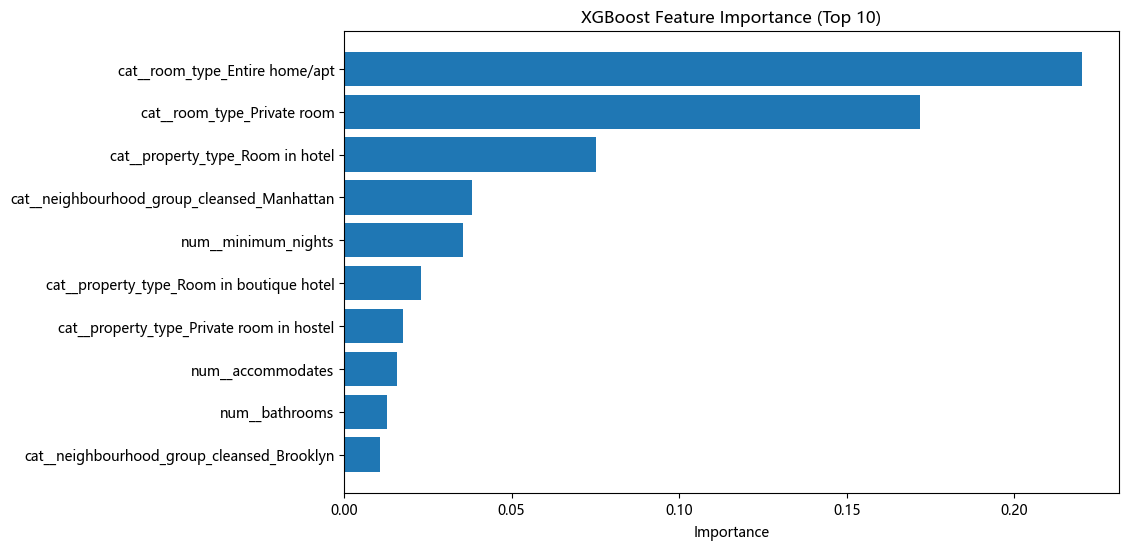

In [126]:
xgb_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False).head(10)
plot_feature_importance(xgb_importance_df, 'XGBoost Feature Importance (Top 10)')

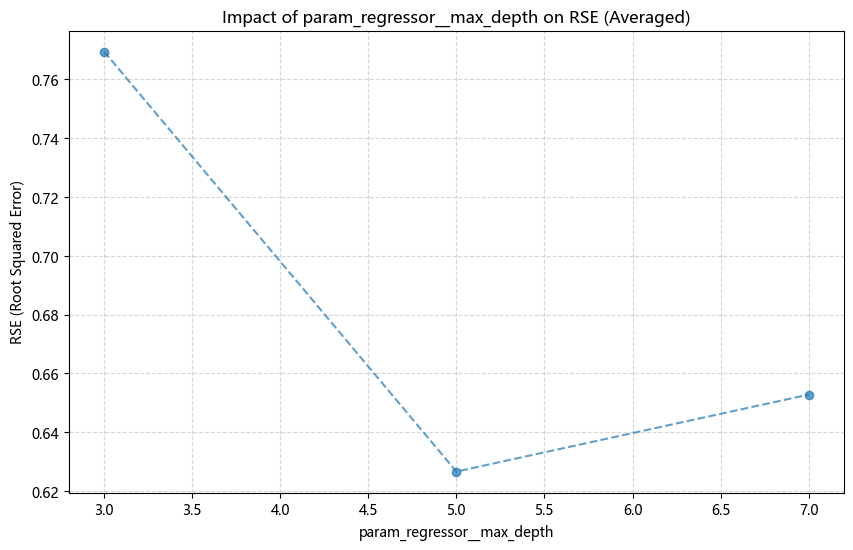

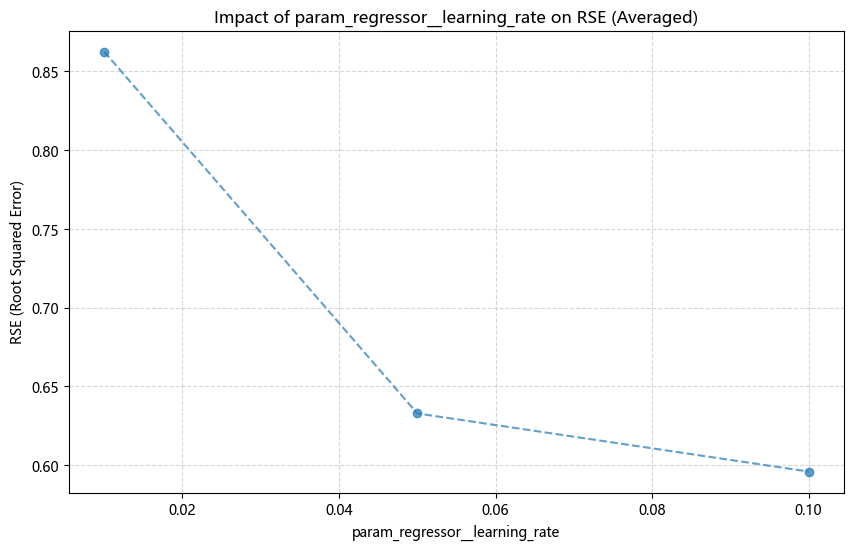

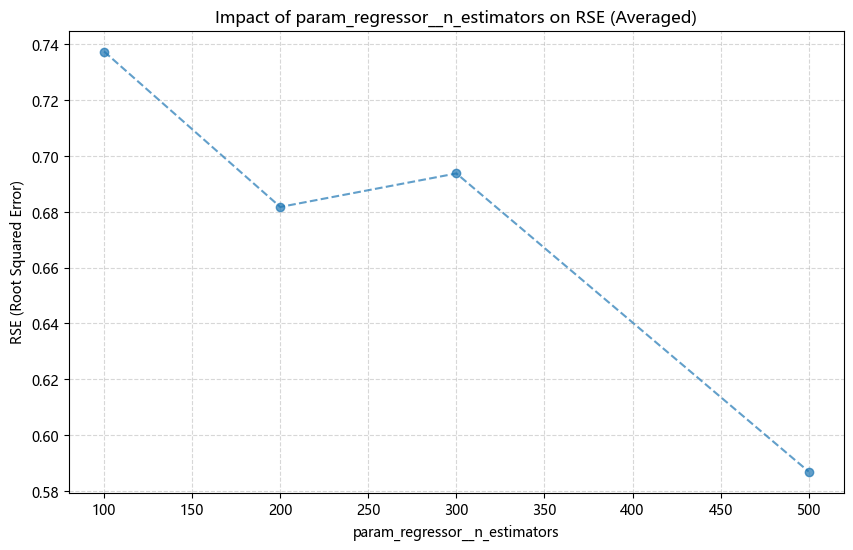

In [68]:
cv_results = pd.DataFrame(random_search.cv_results_)
important_params = [
    'param_regressor__max_depth',
    'param_regressor__learning_rate',
    'param_regressor__n_estimators'
]

for param in important_params:
    if param in cv_results:
        grouped_data = (
            pd.DataFrame({
                param: cv_results[param],
                'RSE': -cv_results['mean_test_score']
            })
            .groupby(param, as_index=False) 
            .mean()
        )
        plt.figure(figsize=(10, 6))
        plt.plot(grouped_data[param], grouped_data['RSE'], marker='o', linestyle='--', alpha=0.7)
        plt.xlabel(param)
        plt.ylabel('RSE (Root Squared Error)')
        plt.title(f'Impact of {param} on RSE (Averaged)')
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()
    else:
        print(f"Parameter {param} not found in cv_results.")